In [53]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras import optimizers
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model
from keras.losses import mean_absolute_error
import tensorflow as tf
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.utils import plot_model

from LRF import LRFinder
from SGDR import SGDRScheduler

In [2]:
train_path = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/augument_data/training_images'
npy_img_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)\\augument_data\\training_images_batches'
architecture_plot_save_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/'

img_width, img_height = 299., 299.
rx = 2.1404
ry = 1.61

In [3]:
##### img_width, img_height = 640, 480
base_dir = 'X:/Flipkart GRID - Object Localization (Medium Complexity Round)/'
# train_data_dir = "X:/train-scene classification/data/train/"
# validation_data_dir = "X:/train-scene classification/data/valid/"
# test_data_dir = "X:/train-scene classification/data/test/"
epochs = 1000
# Save the model according to the conditions  
chkpt_dir = "X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/inceptionresnetv2_lrf_ffdf_chkpt.h5" # Change for every new training session 

In [4]:
# base_model = ResNet50(weights = "imagenet", include_top=False, input_shape = (img_height, img_width, 3), classes = 4)
# base_model = InceptionResNetV2(weights = "imagenet", include_top=False, input_shape = (int(img_height), int(img_width), 3), classes = 4)

In [5]:
# base_model.save('inceptionresnetv2.h5')
base_model = load_model(os.path.join(base_dir,'base_models', 'inceptionresnetv2.h5')) # use this to load from base_models dir
# base_model = load_model(os.path.join(base_dir, 'notebooks', 'inceptionresnetv2_93tr83val_(6-2-19_00.09).h5')) # use this to load from notebooks dir

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [6]:
# plot_model(base_model, to_file= os.path.join(architecture_plot_save_dir, 'inceptiontresnetv2.png'))

In [7]:
for layer in base_model.layers[:-3]:
    layer.trainable = False
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

In [8]:
# for layer in base_model.layers:
#     layer.trainable = False
x = base_model.output
x = Flatten()(x)
# x = Dense(2048, activation="relu")(x)
# x = Dropout(0.7)(x)
# x = Dense(32, activation="relu")(x)
# x = Dropout(0.2)(x)
# x = Dense(16, activation="relu")(x)
# x = Dropout(0.0)(x)
# x = Dense(64, activation="relu")(x)
# x = Dropout(0.0)(x)
# x = Dense(1024, activation="relu")(x)
# x = Dropout(0.5)(x)
# x = Dense(512, activation="relu")(x)
# x = Dropout(0.3)(x)
# predictions = Dense(6, activation="softmax")(x)
predictions = Dense(4, activation="relu")(x)

In [9]:
model = Model(input = base_model.input, output = predictions)
# for layer in model.layers[:-3]:
#     layer.trainable = False
model.summary()

C:\Users\praty\Anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

In [10]:
def mIoU(labels,predictions):
#     print(labels.shape)
#     print(predictions.shape)
#     print(labels[0])
#     print(predictions[0])
    pred_x1=predictions[:,0]#*img_width
    pred_x2=predictions[:,1]#*img_width
    pred_y1=predictions[:,2]#*img_height
    pred_y2=predictions[:,3]#*img_height
    label_x1=labels[:,0]#*img_width
    label_x2=labels[:,1]#*img_width
    label_y1=labels[:,2]#*img_height
    label_y2=labels[:,3]#*img_height
    int_x1 = tf.maximum(pred_x1, label_x1)
    int_x2 = tf.minimum(pred_x2, label_x2)
    int_y1 = tf.maximum(pred_y1, label_y1)
    int_y2 = tf.minimum(pred_y2, label_y2)
    tensor_type = pred_x1.dtype
    pred_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), pred_x2 - pred_x1), tf.maximum(tf.cast(0.0, tensor_type), pred_y2 - pred_y1))
    label_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), label_x2 - label_x1), tf.maximum(tf.cast(0.0, tensor_type), label_y2 - label_y1))
    int_area = tf.multiply(tf.maximum(tf.cast(0.0, tensor_type), int_x2 - int_x1), tf.maximum(tf.cast(0.0, tensor_type), int_y2 - int_y1))
    union_area = pred_area + label_area - int_area
    IoU = int_area / union_area
    return tf.reduce_mean(IoU)

In [11]:
# IoU Metric Test
LABEL = [[0.0, 1.0, 0.0, 1.0], 
        [2.0, 3.0, 2.0, 3.0]]
PRED = [[0.5, 1.5, 0.5, 1.5],
        [2.0, 3.0, 2.0, 3.0]]
LABEL = tf.constant(np.array(LABEL))
PRED = tf.constant(np.array(PRED))
print(mIoU(LABEL, PRED))
with tf.Session() as sess:
    val = sess.run(mIoU(LABEL, PRED))
    print(val)

Tensor("Mean:0", shape=(), dtype=float64)
0.5714285714285714


#### Load best model weights from here, if required.

In [21]:
augment_df = pd.read_csv(os.path.join(base_dir, 'augument_data', 'augmented_train_data.csv'))
augment_val_df = pd.read_csv(os.path.join(base_dir, 'augument_data', 'augmented_val_data.csv'))

In [37]:
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
train_generator=train_datagen.flow_from_dataframe(dataframe=augment_df,
                                            directory=os.path.join(base_dir, 'augument_data', 'resized_training_images'),
                                            x_col='image_name',
                                            y_col=['x1', 'x2', 'y1', 'y2'],
                                            class_mode="other",
                                                  target_size = (299, 299),
                                                  batch_size=32,
                                                  shuffle = True)
valid_generator=valid_datagen.flow_from_dataframe(dataframe=augment_val_df,
                                            directory=os.path.join(base_dir, 'augument_data', 'training_images'),
                                            x_col='image_name',
                                            y_col=['x1', 'x2', 'y1', 'y2'],
                                            class_mode="other",
                                            target_size = (299, 299),
                                            batch_size=32,
                                            shuffle = True)

Found 68000 images.
Found 2000 images.


In [38]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

In [39]:
# model.load_weights(chkpt_dir)
model = load_model(os.path.join(base_dir, 'notebooks', 'inceptionresnetv2_93tr83val_(6-2-19_00.09).h5'), custom_objects = {"mIoU":mIoU})
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_204 (BatchN (None, 149, 149, 32) 96          conv2d_204[0][0]                 
__________________________________________________________________________________________________
activation_204 (Activation)     (None, 149, 149, 32) 0           batch_normalization_204[0][0]    
__________________________________________________________________________________________________
conv2d_205

activation_395 (Activation)     (None, 8, 8, 192)    0           batch_normalization_395[0][0]    
__________________________________________________________________________________________________
activation_398 (Activation)     (None, 8, 8, 256)    0           batch_normalization_398[0][0]    
__________________________________________________________________________________________________
block8_8_mixed (Concatenate)    (None, 8, 8, 448)    0           activation_395[0][0]             
                                                                 activation_398[0][0]             
__________________________________________________________________________________________________
block8_8_conv (Conv2D)          (None, 8, 8, 2080)   933920      block8_8_mixed[0][0]             
__________________________________________________________________________________________________
block8_8 (Lambda)               (None, 8, 8, 2080)   0           block8_7_ac[0][0]                
          

In [40]:
model.compile(loss = mean_absolute_error, optimizer = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8), metrics=[mIoU])

In [41]:
checkpoint = ModelCheckpoint(chkpt_dir, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
early = EarlyStopping(monitor='val_loss', min_delta=0, patience=40, verbose=1, mode='auto')

In [42]:
# train_df = pd.read_csv(os.path.join(base_dir, 'augument_data', 'augmented_train_data.csv'))
# val_df = pd.read_csv(os.path.join(os.path.join(base_dir, 'augument_data', 'augmented_val_data.csv')))

In [43]:
# l = []
# for im in val_df.image_name:
#     img = (cv2.imread(os.path.join(train_path, im))) ### INTRIDUCING NORMALIZATION.
#     img = cv2.resize(img, (int(img_width), int(img_height)))
#     img = (img / 255.).astype(np.float32)
#     l.append(np.expand_dims(img, axis = 0))
# x_val = np.vstack(l)
# print("x_val done.")
# y_val = val_df.iloc[:,1:].values.astype(np.float32)
# y_val[:, 0] = y_val[:, 0] # / img_width
# y_val[:, 1] = y_val[:, 1] # / img_width
# y_val[:, 2] = y_val[:, 2] # / img_height
# y_val[:, 3] = y_val[:, 3] # / img_height
# print(y_val[0])
# print(y_val.dtype)
# print(x_val.shape)


In [44]:
# print(val_df.image_name[0])
# # model.load_weights(chkpt_dir)

In [45]:
# ram_batch_size = 1000
# total_number_images = 68000
# print(total_number_images // ram_batch_size)

In [46]:
def show_img_with_rect(img, lab):
    x1 = int(lab[0]/2.1404)
    x2 = int(lab[1]/2.1404)
    y1 = int(lab[2]/1.61)
    y2 = int(lab[3]/1.61) #
    cv2.rectangle(img,(x1,y1),(x2,y2),(0,255,0),3)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [47]:
# show_img_with_rect(x_val[654], y_val[654])

In [48]:
'''
    lrf = LRFinder(minimum=3e-6, maximum=3e-4, step_size=(train_generator.n//train_generator.batch_size), n_epochs=4)
    model.fit(x_train, y_train, callbacks=[lrf, ])
    lrf.lr_graph()
    lrf.loss_graph()
'''
lrf = LRFinder(minimum=3e-6, maximum=3e-4, step_size=(train_generator.n//train_generator.batch_size), n_epochs=2)

In [49]:
# ctr = 0

# for epoch in range(epochs):
#     print(epoch)
#     print("--------------------------------------------------------------")
#     for i in range(total_number_images // ram_batch_size):
#         print('batch {}/67 (epoch {}):'.format(i, epoch))
#         l = []
# #         for im in train_df.image_name[i * ram_batch_size: (i + 1) * ram_batch_size]:
# #             img = (cv2.imread(os.path.join(train_path, im)) / 255.).astype(np.float32) ### INTRIDUCING NORMALIZATION.
# #             l.append(np.expand_dims(img, axis = 0))
#         x_train = np.load(os.path.join(npy_img_dir, str(i) + '.npy'))
#         y_train = train_df[i * ram_batch_size: (i + 1) * ram_batch_size].iloc[:,1:].values
# #         y_train[:, 0] = y_train[:, 0] # / img_width
# #         y_train[:, 1] = y_train[:, 1] # / img_width
# #         y_train[:, 2] = y_train[:, 2] # / img_height
# #         y_train[:, 3] = y_train[:, 3] # / img_height
# #         plt.figure(i)
# #         show_img_with_rect(x_train[0], y_train[0])
#         model.fit(x=x_train, y=y_train, batch_size=32, epochs=1, verbose=1, callbacks=[checkpoint, lrf], validation_split=0.0, validation_data=(x_val, y_val), shuffle=True)
# #         if i == 0:
# #             pred = model.predict(np.expand_dims(x_train[0], axis=0))
# #             X1 = int(pred[0][0]/rx)
# #             X2 = int(pred[0][1]/rx)
# #             Y1 = int(pred[0][2]/ry)
# #             Y2 = int(pred[0][3]/ry)
# #             cv2.rectangle(x_train[0],(X1,Y1),(X2,Y2),(0,255,0),3)
# #             plt.figure(ctr)
# #             ctr += 1
# #             plt.imshow(cv2.cvtColor(x_train[0], cv2.COLOR_BGR2RGB))

model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=2,
                    verbose=1,
                    callbacks=[checkpoint, lrf],
                    shuffle=True)

Epoch 1/2
2125/2125 [==============================] - 612s 288ms/step - loss: 7.3818 - mIoU: 0.9105 - val_loss: 17.7610 - val_mIoU: 0.8013

Epoch 00001: val_loss improved from inf to 17.76100, saving model to X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/inceptionresnetv2_lrf_ffdf_chkpt.h5
Epoch 2/2
2125/2125 [==============================] - 606s 285ms/step - loss: 6.8399 - mIoU: 0.9165 - val_loss: 16.8016 - val_mIoU: 0.8113

Epoch 00002: val_loss improved from 17.76100 to 16.80164, saving model to X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/inceptionresnetv2_lrf_ffdf_chkpt.h5


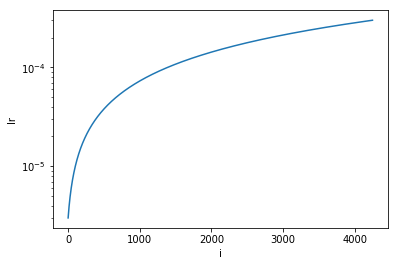

In [50]:
lrf.lr_graph()

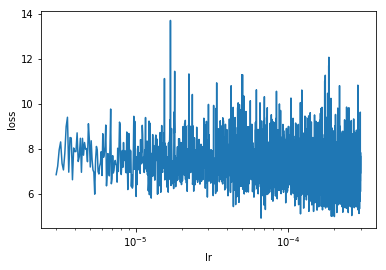

In [51]:
lrf.loss_graph()

In [54]:
schedule = SGDRScheduler(min_lr=1e-6,
                         max_lr=1e-4,
                         steps_per_epoch=STEP_SIZE_TRAIN,
                         lr_decay=0.9,
                         cycle_length=2,
                         mult_factor=1.5)

In [55]:
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=1000,
                    verbose=1,
                    callbacks=[checkpoint, schedule],
                    shuffle=True)

Epoch 1/1000
2125/2125 [==============================] - 610s 287ms/step - loss: 6.2219 - mIoU: 0.9233 - val_loss: 17.0702 - val_mIoU: 0.8086

Epoch 00001: val_loss did not improve from 16.80164
Epoch 2/1000
2125/2125 [==============================] - 607s 286ms/step - loss: 6.0072 - mIoU: nan - val_loss: 17.0043 - val_mIoU: 0.8090

Epoch 00002: val_loss did not improve from 16.80164
Epoch 3/1000
2125/2125 [==============================] - 603s 284ms/step - loss: 5.9708 - mIoU: 0.9262 - val_loss: 16.8475 - val_mIoU: 0.8106

Epoch 00003: val_loss did not improve from 16.80164
Epoch 4/1000
2125/2125 [==============================] - 604s 284ms/step - loss: 5.7811 - mIoU: 0.9284 - val_loss: 16.5998 - val_mIoU: 0.8141

Epoch 00004: val_loss improved from 16.80164 to 16.59984, saving model to X:/Flipkart GRID - Object Localization (Medium Complexity Round)/chkpts/inceptionresnetv2_lrf_ffdf_chkpt.h5
Epoch 5/1000
2125/2125 [==============================] - 605s 285ms/step - loss: 5.6981 

KeyboardInterrupt: 

In [ ]:
model.save('inceptionresnetv2_l1loss.h5')

In [ ]:
model.load_weights(chkpt_dir)

In [ ]:
for i in range(0, 2000, 100):
    pred = model.predict(np.expand_dims(x_val[i], axis=0))
    a1 = int(pred[0][0]/rx)
    a2 = int(pred[0][1]/rx)
    b1 = int(pred[0][2]/ry)
    b2 = int(pred[0][3]/ry)
    test_img = x_val[i]
    print(test_img.shape)
    plt.figure(i)
    cv2.rectangle(test_img,(a1,b1),(a2,b2),(0,255,0),3)
    plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [ ]:
test_img = x_val[7]
test_img = np.expand_dims(test_img, axis=0)
pred = model.predict(test_img)
print(pred.shape)
a1 = int(pred[0][0]/rx)
a2 = int(pred[0][1]/rx)
b1 = int(pred[0][2]/ry)
b2 = int(pred[0][3]/ry)
test_img = test_img[0]
cv2.rectangle(test_img,(a1,b1),(a2,b2),(0,255,0),3)
plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))

In [ ]:
model.save('kuchcha_inception_resnet_v2.h5')

In [ ]:
model.load_weights(chkpt_dir)
LABEL = y_val
PRED = model.predict(x_val)
with tf.Session() as sess:
    val = sess.run(mIoU(LABEL, PRED))
    print(val)

In [ ]:
test_df = pd.read_csv(os.path.join('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data', 'test.csv'))

In [ ]:
print(type(test_df))

In [ ]:
for i, im in enumerate(test_df.image_name):
    img = cv2.imread(os.path.join('X:/Flipkart GRID - Object Localization (Medium Complexity Round)/orig_data/train', im))